In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
from utility_functions import *

In [2]:
warnings.filterwarnings('ignore', 'No format checks')

In [3]:
msd_up = 200
msd_down = 40
pt_up = 600
pt_down = 450

In [4]:
#use = 'hbb'
use = 'hgg'
if use == 'hgg':
    signal, model1, model2, model3, model4, scaler1, scaler2, scaler3, scaler4 = signal_read_in('hgg', msd_up, msd_down, pt_up, pt_down)
else:
    signal, model, scaler = signal_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

In [5]:
bkg_dict = {}
bkg_dict['qcd'] = bkg_read_in('qcd', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ttboosted'] = bkg_read_in('ttboosted', msd_up, msd_down, pt_up, pt_down)
bkg_dict['wqq'] = bkg_read_in('wqq', msd_up, msd_down, pt_up, pt_down)
bkg_dict['zqq'] = bkg_read_in('zqq', msd_up, msd_down, pt_up, pt_down)
bkg_dict['singletop'] = bkg_read_in('singletop', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ww'] = bkg_read_in('ww', msd_up, msd_down, pt_up, pt_down)
bkg_dict['wz'] = bkg_read_in('wz', msd_up, msd_down, pt_up, pt_down)
bkg_dict['zz'] = bkg_read_in('zz', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ww4q'] = bkg_read_in('ww4q', msd_up, msd_down, pt_up, pt_down)
if use == 'hgg':
    bkg_dict['hbb'] = bkg_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

In [6]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                'n2b1': fatjets['FatJets.n2b1'],
                'n3b1': fatjets['FatJets.n3b1'],
                'nConstituents': fatjets['FatJets.nConstituents'],
                #'color_ring': fatjets['FatJets.color_ring'],
                'd2b1': fatjets['FatJets.d2b1'],
                'u1': fatjets['FatJets.u1'],
                'u2': fatjets['FatJets.u2'],
                'u3': fatjets['FatJets.u3'],
                'd3': fatjets['FatJets.d3'],
                'm2': fatjets['FatJets.m2'],
                'm3': fatjets['FatJets.m3'],
                'n4': fatjets['FatJets.n4'],
                #'mratio': fatjets['FatJets.mratio'],
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [7]:
taggers = {}
taggers['qt'] = EnergyCorrelatorFunctionTagger(model1)
taggers['dt'] = EnergyCorrelatorFunctionTagger(model2)
taggers['ht'] = EnergyCorrelatorFunctionTagger(model3)
taggers['st'] = EnergyCorrelatorFunctionTagger(model4)
tagger_names = list(taggers.keys())

scalers = {}
scalers['qcd_scaler'] = scaler1
scalers['diboson_scaler'] = scaler2
scalers['hbb_scaler'] = scaler3
scalers['singletop_tagger'] = scaler4
scaler_names = list(scalers.keys())

def tagger_scores(sample):
    scores = {}
    for i in range(len(taggers)):
        scores[tagger_names[i]] = taggers[tagger_names[i]](sample, scalers[scaler_names[i]])[:,0]
    return scores

scores = {}
scores['signal'] = tagger_scores(signal)

for j in bkg_dict:
    scores[j] = tagger_scores(bkg_dict[j])

In [8]:
qcd_pop = ['qcd', 'ttboosted', 'wqq', 'zqq']
db_pop = ['ww', 'zz', 'wz', 'ww4q']

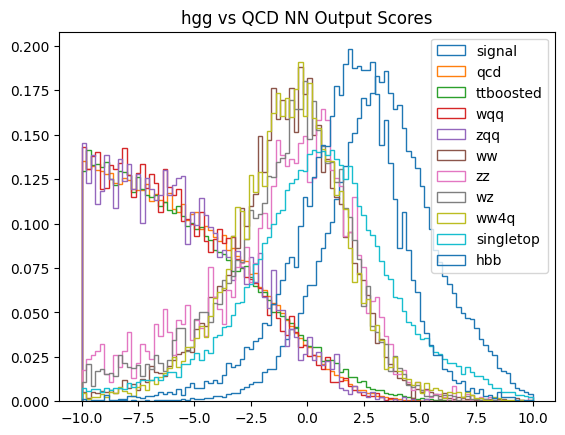

In [9]:
pltrange = (-10, 10)
score_plotter(scores['signal']['qt'], 'signal', pltrange)
for i in qcd_pop:
    score_plotter(scores[i]['qt'], i, pltrange)
for i in db_pop:
    score_plotter(scores[i]['qt'], i, pltrange)
score_plotter(scores['singletop']['qt'], 'singletop', pltrange)
score_plotter(scores['hbb']['qt'], 'hbb', pltrange)
plt.title(f'{use} vs QCD NN Output Scores')
plt.legend()
plt.show()

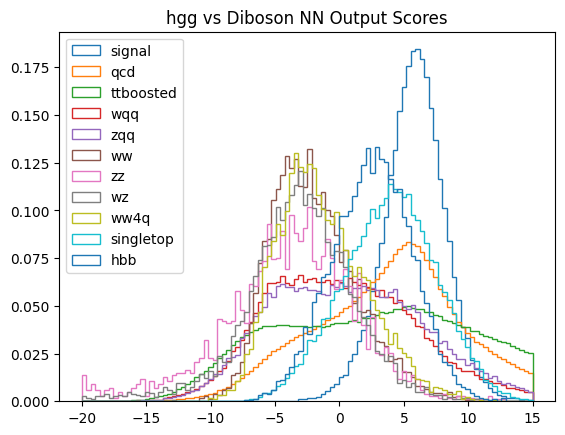

In [10]:
pltrange = (-20,15)
score_plotter(scores['signal']['dt'], 'signal', pltrange)
for i in qcd_pop:
    score_plotter(scores[i]['dt'], i, pltrange)
for i in db_pop:
    score_plotter(scores[i]['dt'], i, pltrange)
score_plotter(scores['singletop']['dt'], 'singletop', pltrange)
score_plotter(scores['hbb']['dt'], 'hbb', pltrange)
plt.title(f'{use} vs Diboson NN Output Scores')
plt.legend()
plt.show()

In [7]:
pltrange = (-10,10)
score_plotter(scores['signal']['ht'], 'signal', pltrange)
# for i in qcd_pop:
#     score_plotter(scores[i]['ht'], i, pltrange)
# for i in db_pop:
#     score_plotter(scores[i]['ht'], i, pltrange)
# score_plotter(scores['singletop']['ht'], 'singletop', pltrange)
score_plotter(scores['hbb']['ht'], 'hbb', pltrange)
plt.title(f'{use} vs Hbb NN Output Scores')
plt.legend()
plt.show()

NameError: name 'scores' is not defined

In [8]:
pltrange = (-10,10)
score_plotter(scores['signal']['st'], 'signal', pltrange)
# for i in qcd_pop:
#     score_plotter(scores[i]['st'], i, pltrange)
# for i in db_pop:
#     score_plotter(scores[i]['st'], i, pltrange)
score_plotter(scores['singletop']['st'], 'singletop', pltrange)
score_plotter(scores['hbb']['st'], 'hbb', pltrange)
plt.title(f'{use} vs Singletop NN Output Scores')
plt.legend()
plt.show()

NameError: name 'scores' is not defined

In [9]:
aucs = {}
for i in bkg_dict:
    aucs[i] = sample_auc(i, scores)

NameError: name 'bkg_dict' is not defined

In [14]:
aucs

{'qcd': {'qt': 0.9985111976987666,
  'dt': 0.5982240501799443,
  'ht': 0.5000648868539815,
  'st': 0.5718573978170334},
 'ttboosted': {'qt': 0.9987413890094173,
  'dt': 0.5898414444178837,
  'ht': 0.6839436050104057,
  'st': 0.6756714483294675},
 'wqq': {'qt': 0.9982786245534874,
  'dt': 0.8122517163888108,
  'ht': 0.8669668952807075,
  'st': 0.7890882088869855},
 'zqq': {'qt': 0.9982055415927724,
  'dt': 0.7804354382013365,
  'ht': 0.8692461203873885,
  'st': 0.7749321791746737},
 'singletop': {'qt': 0.7689794845890867,
  'dt': 0.6678577620529872,
  'ht': 0.6727592100481391,
  'st': 0.7893516943665707},
 'ww': {'qt': 0.8922725234165269,
  'dt': 0.9611371624210842,
  'ht': 0.9170301491767707,
  'st': 0.9497612665128083},
 'wz': {'qt': 0.9014005958467725,
  'dt': 0.971762785147211,
  'ht': 0.9464190650360615,
  'st': 0.9648891593171939},
 'zz': {'qt': 0.9086531896044217,
  'dt': 0.9663621656006947,
  'ht': 0.9440317125485564,
  'st': 0.9623090790155774},
 'ww4q': {'qt': 0.88427516806356

In [12]:
qcd_hist = make_hist('qcd', scores['qcd']['qt'])
hgg_hist = make_hist('hgg', scores['signal']['qt'])

In [10]:
ak.min(scores['qcd']['qt']), ak.max(scores['qcd']['qt']), ak.min(scores['signal']['qt']), ak.max(scores['signal']['qt'])

(-480.87912, 8.718506, -39.46598, 11.185974)

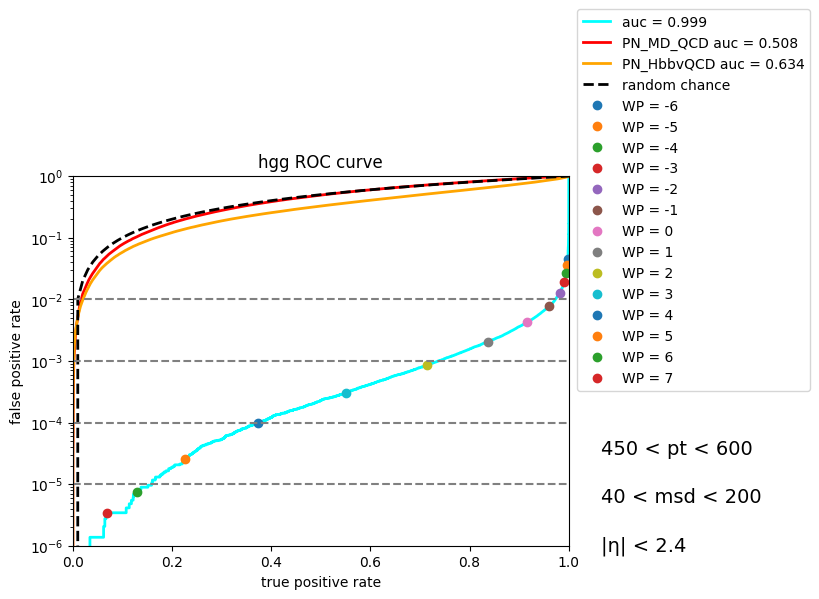

In [13]:
roc_maker(signal, bkg_dict['qcd'], hgg_hist, qcd_hist, scores['signal']['qt'], scores['qcd']['qt'], 
          use, pt_up, pt_down, msd_up, msd_down, True)

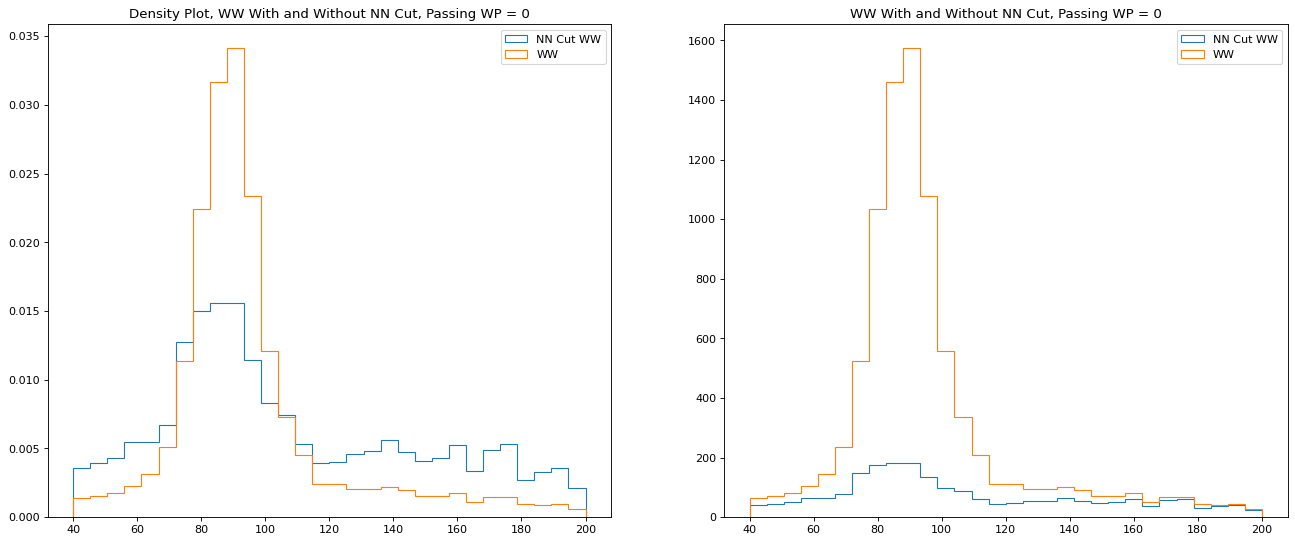

<Figure size 640x480 with 0 Axes>

In [14]:
msd_double_plotter(bkg_dict['ww'], scores['ww']['dt'], 0, False, label='WW')

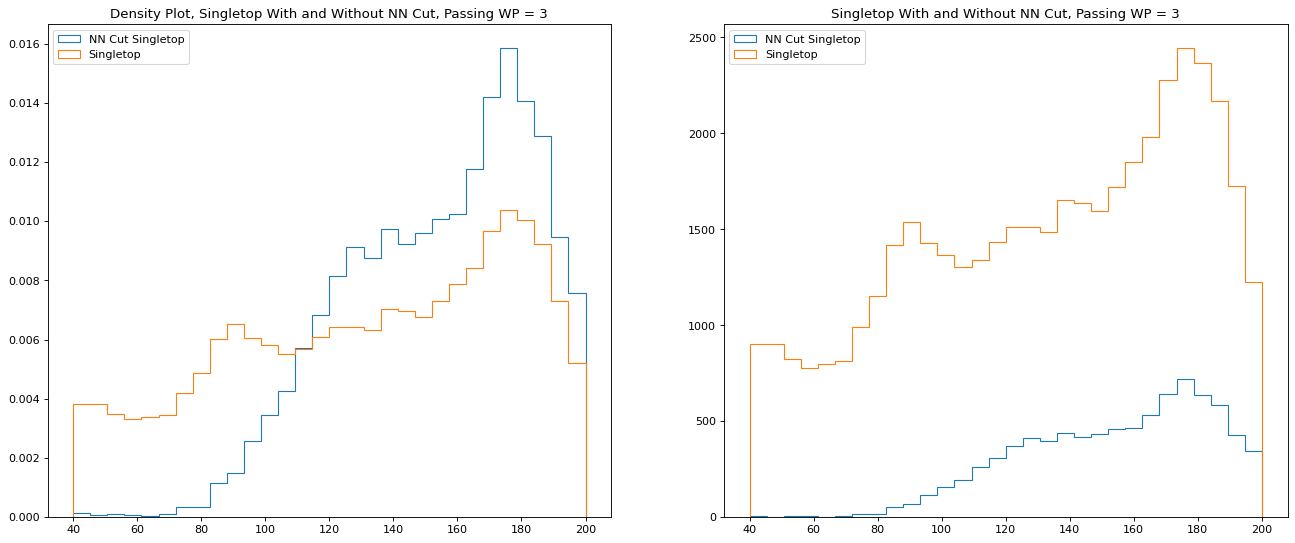

<Figure size 640x480 with 0 Axes>

In [19]:
msd_double_plotter(bkg_dict['singletop'], scores['singletop']['qt'], 3, False, label='Singletop')

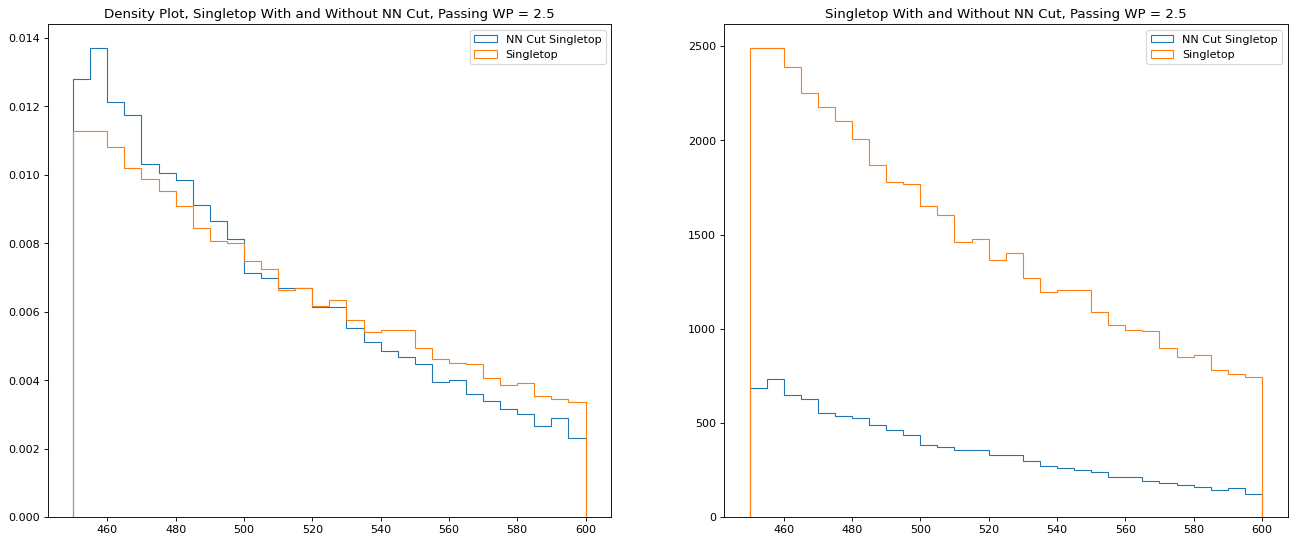

<Figure size 640x480 with 0 Axes>

In [20]:
pt_double_plotter(bkg_dict['singletop'], scores['singletop']['st'], 2.5, False, label='Singletop')

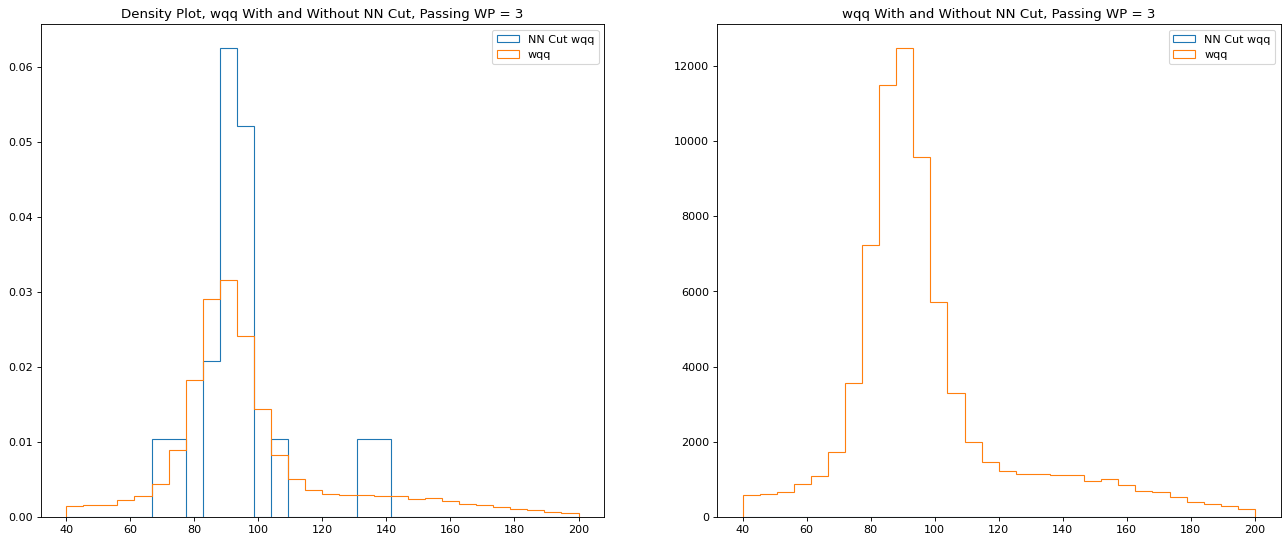

<Figure size 640x480 with 0 Axes>

In [21]:
msd_double_plotter(bkg_dict['wqq'], scores['wqq']['qt'], 3, False, label='wqq')

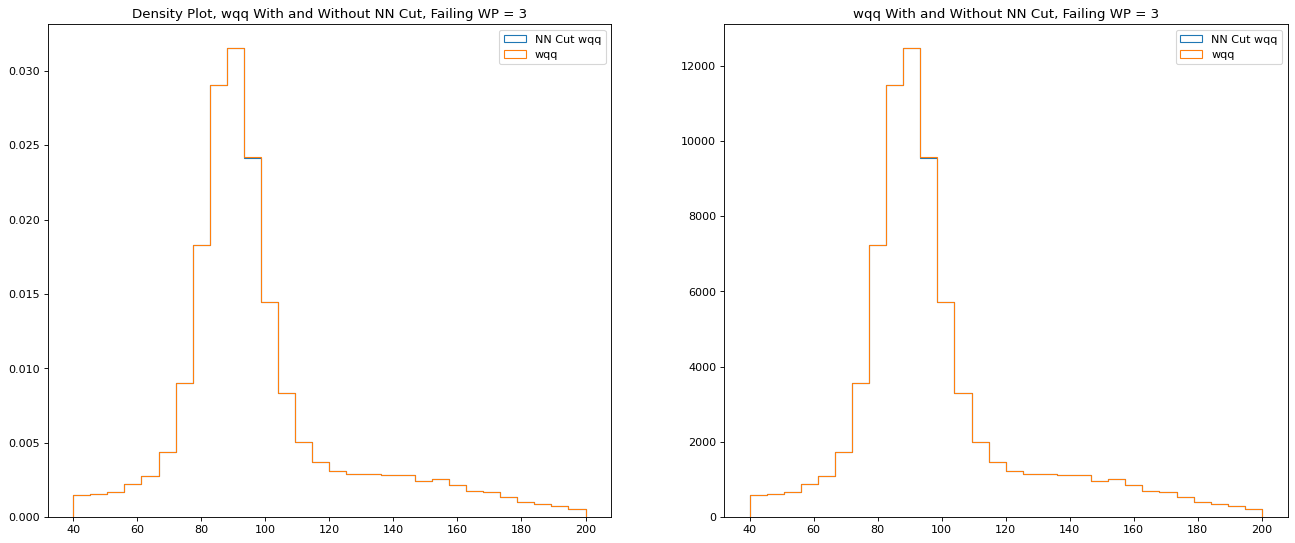

<Figure size 640x480 with 0 Axes>

In [22]:
msd_double_plotter(bkg_dict['wqq'], scores['wqq']['qt'], 3, True, label='wqq')

In [25]:
def bkg_output_hist(sample, sample_score, wp, fail):
    if fail:
        mask = ~((sample_score['qt'] > wp) & (sample_score['dt'] > wp) & (sample_score['ht'] > wp)) #& (sample_score['st'] < wp)
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][mask]
    else:
        mask = (sample_score['qt'] > wp) & (sample_score['dt'] > wp) & (sample_score['ht'] > wp) #& (sample_score['st'] > wp)
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][mask]
    msd_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"{sample} MSD").Weight()
    msd_hist.fill(msd=sample_cut_msd)
    return msd_hist

In [26]:
pass_hists = {}
#del(bkg_dict['ww4q'])
for i in bkg_dict:
    msd_hist = bkg_output_hist(i, scores[i], wp=0, fail=False)
    pass_hists[i] = msd_hist
    # with open(f'output_hists/pass/{use}_vs_{i}_pass_wp_3.pkl', 'wb') as f:
    #     pickle.dump(msd_hist, f)

In [27]:
fail_hists = {}
for i in bkg_dict:
    msd_hist = bkg_output_hist(i, scores[i], wp=0, fail=True)
    fail_hists[i] = msd_hist
    # with open(f'output_hists/fail/{use}_vs_{i}_fail_wp_3.pkl', 'wb') as f:
    #     pickle.dump(msd_hist, f)

In [28]:
pass_hists['qcd']

Hist(Regular(40, 40, 200, name='msd', label='qcd MSD'), storage=Weight()) # Sum: WeightedSum(value=5837, variance=5837)

In [29]:
fail_hists['qcd']

Hist(Regular(40, 40, 200, name='msd', label='qcd MSD'), storage=Weight()) # Sum: WeightedSum(value=1.45313e+06, variance=1.45313e+06)

In [39]:
wp = 0
mask = (sig_scores['qt'] < wp) & (sig_scores['dt'] < wp) & (sig_scores['ht'] < wp) #& (sig_scores['st'] < wp)
sample_cut_msd = signal['FatJets.msoftdrop'][mask]
sig_fail_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"{use} MSD").Weight()
sig_fail_hist.fill(msd=sample_cut_msd);

In [40]:
wp = 0
mask = (sig_scores['qt'] > wp) & (sig_scores['dt'] > wp) & (sig_scores['ht'] > wp) #& (sig_scores['st'] > wp)
sample_cut_msd = signal['FatJets.msoftdrop'][mask]
sig_pass_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"{use} MSD").Weight()
sig_pass_hist.fill(msd=sample_cut_msd);

In [41]:
with open('my_xsecs.json', 'rb') as f:
    xsecs = json.load(f)
with open('event_total.json', 'rb') as f:
    event_totals = json.load(f)

In [42]:
scaleHgg = ((44.99*(xsecs['hgg']*1000)*0.0817)/(event_totals['hgg']))
sig_fail_hist.view(flow=True)[:] *= scaleHgg
sig_pass_hist.view(flow=True)[:] *= scaleHgg
with open(f'output_hists/fail/hgg/{use}_fail_wp_0.pkl', 'wb') as f:
    pickle.dump(sig_fail_hist, f)
with open(f'output_hists/pass/hgg/{use}_pass_wp_0.pkl', 'wb') as f:
    pickle.dump(sig_pass_hist, f)

In [43]:
del(xsecs['hgg'])
del(event_totals['hgg'])

In [44]:
scaleHbb = ((44.99*(xsecs['hbb']*1000)*0.581)/(event_totals['hbb']))
hbb_fail_hist = fail_hists['hbb']
hbb_fail_hist.view(flow=True)[:] *= scaleHbb
hbb_pass_hist = pass_hists['hbb']
hbb_pass_hist.view(flow=True)[:] *= scaleHbb
with open(f'output_hists/pass/hgg/hgg_vs_hbb_pass_wp_0.pkl', 'wb') as f:
    pickle.dump(hbb_pass_hist, f)
with open(f'output_hists/fail/hgg/hgg_vs_hbb_fail_wp_0.pkl', 'wb') as f:
    pickle.dump(hbb_fail_hist, f)

In [45]:
del(xsecs['hbb'])
del(event_totals['hbb'])
del(pass_hists['hbb'])
del(fail_hists['hbb'])

In [46]:
scaled_pass_hists = {}
for i in pass_hists:
    hist2scale = pass_hists[i]
    scale = ((44.99*(xsecs[i]*1000))/event_totals[i])
    hist2scale.view(flow=True)[:] *= scale
    scaled_pass_hists[i] = hist2scale

In [47]:
scaled_fail_hists = {}
for i in fail_hists:
    hist2scale = fail_hists[i]
    scale = ((44.99*(xsecs[i]*1000))/event_totals[i])
    hist2scale.view(flow=True)[:] *= scale
    scaled_fail_hists[i] = hist2scale

In [48]:
for i in scaled_pass_hists:
    with open(f'output_hists/pass/hgg/{use}_vs_{i}_pass_wp_0.pkl', 'wb') as f:
        pickle.dump(scaled_pass_hists[i], f)
for i in scaled_fail_hists:
    with open(f'output_hists/fail/hgg/{use}_vs_{i}_fail_wp_0.pkl', 'wb') as f:
        pickle.dump(scaled_fail_hists[i], f)

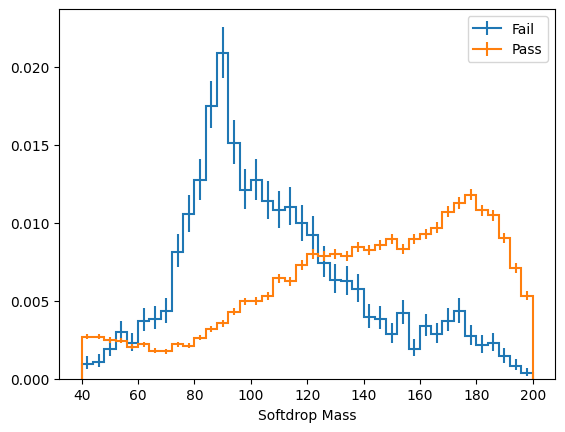

In [49]:
fig, ax = plt.subplots()
fail_hists['singletop'].plot1d(density=True, label='Fail')
pass_hists['singletop'].plot1d(density=True, label='Pass')
plt.legend()
plt.xlabel('Softdrop Mass')
plt.show()

In [ ]:
fail_hists['qcd']

In [ ]:
pass_hists['qcd']

In [87]:
file = uproot.open('~/Public/combine/CMSSW_13_3_2/src/rhalphalib/run_scripts/hgg_out/testModel/fitDiagnosticsTest.root')

In [88]:
file2 = uproot.open('~/Public/combine/CMSSW_13_3_2/src/test_combine/datacards/signal-strength/testModel/fitDiagnosticsTest.root')

In [89]:
file3 = uproot.open('~/Public/combine/CMSSW_13_3_2/src/rhalphalib/run_scripts/hbb_out/testModel/fitDiagnosticsTest.root')

In [119]:
file["shapes_prefit/ptbin0pass/singletop;1"].to_hist() + file["shapes_prefit/ptbin0fail/singletop;1"].to_hist()

Hist(Variable(array([ 40.,  44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,
        84.,  88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124.,
       128., 132., 136., 140., 144., 148., 152., 156., 160., 164., 168.,
       172., 176., 180., 184., 188., 192., 196., 200.]), name='xaxis', label='msd'), storage=Weight()) # Sum: WeightedSum(value=106.453, variance=0)

In [126]:
file["shapes_prefit/ptbin0pass/singletop;1"].to_hist()

Hist(Variable(array([ 40.,  44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,
        84.,  88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124.,
       128., 132., 136., 140., 144., 148., 152., 156., 160., 164., 168.,
       172., 176., 180., 184., 188., 192., 196., 200.]), name='xaxis', label='msd'), storage=Weight()) # Sum: WeightedSum(value=93.0915, variance=0)

In [123]:
file["shapes_prefit/ptbin0fail/singletop;1"].to_hist()

Hist(Variable(array([ 40.,  44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,
        84.,  88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124.,
       128., 132., 136., 140., 144., 148., 152., 156., 160., 164., 168.,
       172., 176., 180., 184., 188., 192., 196., 200.]), name='xaxis', label='msd'), storage=Weight()) # Sum: WeightedSum(value=13.362, variance=0)

In [117]:
file2['shapes_prefit/ptbin0ggfpass2017/singlet;1'].to_hist()

Hist(Variable(array([ 40.,  47.,  54.,  61.,  68.,  75.,  82.,  89.,  96., 103., 110.,
       117., 124., 131., 138., 145., 152., 159., 166., 173., 180., 187.,
       194., 201.]), name='xaxis', label='msd'), storage=Weight()) # Sum: WeightedSum(value=1.30071, variance=0)

In [118]:
sum([
    file2[k].to_hist() for k in file2.keys()
    if k.startswith("shapes_prefit/ptbin")
    and k[19:20] in "012"
    and "2017" in k
    and k.endswith("singlet;1")
])

Hist(Variable(array([ 40.,  47.,  54.,  61.,  68.,  75.,  82.,  89.,  96., 103., 110.,
       117., 124., 131., 138., 145., 152., 159., 166., 173., 180., 187.,
       194., 201.]), name='xaxis', label='msd'), storage=Weight()) # Sum: WeightedSum(value=260.049, variance=0)

In [102]:
len("shapes_prefit/ptbin")

19

In [106]:
file3["shapes_prefit/ptbin0pass/hbb;1"].to_hist() + file3["shapes_prefit/ptbin0fail/hbb;1"].to_hist()
#.plot1d(density=False)
#file["shapes_prefit/ptbin0fail/qcd;1"].to_hist().plot1d(density=False)

Hist(Variable(array([ 40.,  44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,
        84.,  88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124.,
       128., 132., 136., 140., 144., 148., 152., 156., 160., 164., 168.,
       172., 176., 180., 184., 188., 192., 196., 200.]), name='xaxis', label='msd'), storage=Weight()) # Sum: WeightedSum(value=0.5125, variance=0)

In [ ]:
# samples = os.listdir("/project01/ndcms/cmoore24/samples")
# samples
# stitched_samples = ['qcd', 'ttboosted', 'wqq', 'zqq']
# standalone_samples = ['hgg', 'hbb', 'singletop']
# diboson_samples = ['ww', 'wz', 'zz']

In [ ]:
# event_totals = {}
# for i in stitched_samples:
#     dirs = os.listdir(f'/project01/ndcms/cmoore24/samples/{i}')
#     region_files = {}
#     for j in dirs:
#         nopath_files = os.listdir(f"/project01/ndcms/cmoore24/samples/{i}/{j}")
#         path_files = [f"/project01/ndcms/cmoore24/samples/{i}/{j}/" + file for file in nopath_files]
#         region_files[j] = path_files
#     nevents = {}
#     for sample, files in region_files.items():
#         nevents[sample] = sum(item[2] for item in uproot.num_entries({file: "Events" for file in files}))
#     total_events = 0
#     for k in nevents:
#         total_events += nevents[k]
#     event_totals[i] = total_events

In [ ]:
# for i in standalone_samples:
#     nopath_files = os.listdir(f"/project01/ndcms/cmoore24/samples/{i}/")
#     path_files = [f"/project01/ndcms/cmoore24/samples/{i}/" + file for file in nopath_files] 
#     events = sum(item[2] for item in uproot.num_entries({file: "Events" for file in path_files}))
#     event_totals[i] = events

# for i in diboson_samples:
#     nopath_files = os.listdir(f"/project01/ndcms/cmoore24/samples/diboson/{i}/")
#     path_files = [f"/project01/ndcms/cmoore24/samples/diboson/{i}/" + file for file in nopath_files] 
#     events = sum(item[2] for item in uproot.num_entries({file: "Events" for file in path_files}))
#     event_totals[i] = events

In [ ]:
# with open('event_total.json', 'w') as f:
#     json.dump(event_totals, f)

In [ ]:
# with open('xsec.json', 'rb') as f:
#     xsecs = json.load(f)
# xsecs
# my_xsecs = {}
# my_xsecs['hbb'] = xsecs['GluGluHToBB']
# my_xsecs['hgg'] = 0.471
# my_xsecs['qcd'] = xsecs['QCD_Pt_300to470']
# my_xsecs['wqq'] = xsecs['WJetsToQQ_HT-600to800']
# my_xsecs['zqq'] = xsecs['ZJetsToQQ_HT-600to800']
# my_xsecs['ttboosted'] = xsecs['TT_MTT700To1000']
# my_xsecs['singletop'] = 7.104
# my_xsecs['ww'] = xsecs['WW']
# my_xsecs['wz'] = xsecs['WZ']
# my_xsecs['zz'] = xsecs['ZZ']
# with open('my_xsecs.json', 'w') as f:
#     json.dump(my_xsecs, f)

In [33]:
def plotter(sample, sample_score, density, wp, fail, var):
    if fail:
        sample_cut_msd = bkg_dict[sample][f'FatJets.{var}'][sample_score < wp]
        regime = 'Failing'
    else:
        sample_cut_msd = bkg_dict[sample][f'FatJets.{var}'][sample_score > wp]
        regime = 'Passing'
    plt.hist(sample_cut_msd, range=(0,0.5), bins=30, density=density, histtype='step', label=f'NN Cut {sample}')
    plt.hist(bkg_dict[sample][f'FatJets.{var}'], range=(0,0.5), bins=30, density=density, histtype='step', label=sample)
    plt.legend()
    if density:
        plt.title(f'Density Plot, {sample} With and Without NN Cut, {regime} WP = {wp}')
    else:
        plt.title(f'{sample} With and Without NN Cut, {regime} WP = {wp}')
    plt.show()

In [34]:
def var_plotter(sample1, sample1_score, sample2, sample2_score, sample3, sample3_score, var, fail, wp=0, density=True):
    if fail:
        sample1_var = bkg_dict[sample1][f'FatJets.{var}'][sample1_score < wp]
        sample2_var = bkg_dict[sample2][f'FatJets.{var}'][sample2_score < wp]
        sample3_var = bkg_dict[sample3][f'FatJets.{var}'][sample3_score < wp]
        regime = 'Failing'
    else:
        sample1_var = bkg_dict[sample1][f'FatJets.{var}'][sample1_score > wp]
        sample2_var = bkg_dict[sample2][f'FatJets.{var}'][sample2_score > wp]
        sample3_var = bkg_dict[sample3][f'FatJets.{var}'][sample3_score > wp]
        regime = 'Passing'

    max_val = max(ak.max(sample1_var), ak.max(sample2_var), ak.max(sample3_var))
    #max_val = 30
    min_val = min(ak.min(sample1_var), ak.min(sample2_var), ak.min(sample3_var))
    #min_val = 4

    plt.hist(sample1_var, range=(min_val,max_val), bins=40, density=density, histtype='step', 
             label=f'{sample1}')
    plt.hist(sample2_var, range=(min_val,max_val), bins=40, density=density, histtype='step', 
             label=f'{sample2}')
    plt.hist(sample3_var, range=(min_val,max_val), bins=40, density=density, histtype='step', 
             label=f'{sample3}')
    plt.legend()

    if density:
        plt.title(f'Density Plot, {var} With and Without NN Cut, {regime} WP = {wp}')
    else:
        plt.title(f'{var} With and Without NN Cut, {regime} WP = {wp}')
    plt.show()

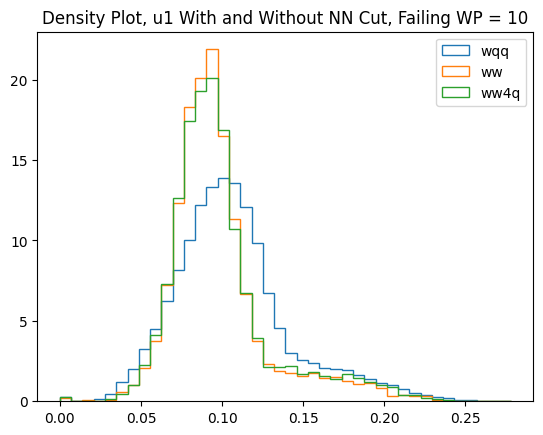

In [49]:
var_plotter('wqq', wqq_score, 'ww', ww_score, 'ww4q', ww4q_score, 'u1', True, wp=10, density=True)

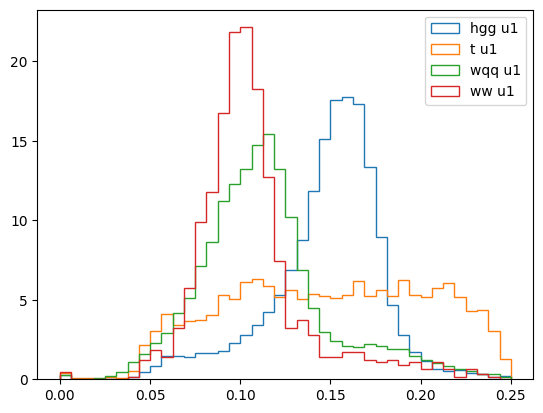

In [88]:
myvar = lambda dataset: dataset["FatJets.mass"]**2/dataset["FatJets.pt"]**2
myvar = lambda dataset: dataset["FatJets.u1"][dataset["FatJets.pt"]<460]
myrange = (0, 0.25)
plt.hist(myvar(signal), range=myrange, bins=40, density=True, histtype='step', 
         label=f'hgg u1')
plt.hist(myvar(bkg_dict['singletop']), range=myrange, bins=40, density=True, histtype='step', 
         label=f't u1')
plt.hist(myvar(bkg_dict['wqq']), range=myrange, bins=40, density=True, histtype='step', 
         label=f'wqq u1')
plt.hist(myvar(bkg_dict['ww']), range=myrange, bins=40, density=True, histtype='step', 
         label=f'ww u1')
plt.legend()
#plt.yscale("log")
plt.show()